Mounted at /content/drive

📁 Dataset Validation:
✅ /content/drive/MyDrive/dataset/train/Degradable - 361 images
✅ /content/drive/MyDrive/dataset/train/Non degradable - 363 images
✅ /content/drive/MyDrive/dataset/valid/Degradable - 45 images
✅ /content/drive/MyDrive/dataset/valid/Non degradable - 46 images
✅ /content/drive/MyDrive/dataset/test/Degradable - 45 images
✅ /content/drive/MyDrive/dataset/test/Non degradable - 45 images



🚀 Training with lr=0.0001, optimizer=Adam, batch_size=16
📈 Epoch 1/3 - Train Accuracy: 95.72%
📈 Epoch 2/3 - Train Accuracy: 75.41%
📈 Epoch 3/3 - Train Accuracy: 91.44%
✅ Final Validation Accuracy: 82.42%

🚀 Training with lr=0.0001, optimizer=Adam, batch_size=32
📈 Epoch 1/3 - Train Accuracy: 94.61%
📈 Epoch 2/3 - Train Accuracy: 99.17%
📈 Epoch 3/3 - Train Accuracy: 100.00%
✅ Final Validation Accuracy: 95.60%

🚀 Training with lr=0.0001, optimizer=SGD, batch_size=16
📈 Epoch 1/3 - Train Accuracy: 90.75%
📈 Epoch 2/3 - Train Accuracy: 93.37%
📈 Epoch 3/3 - Train Acc

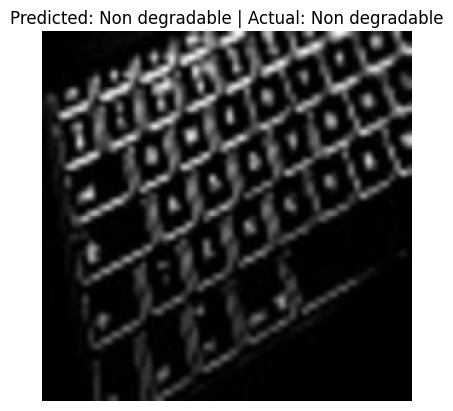

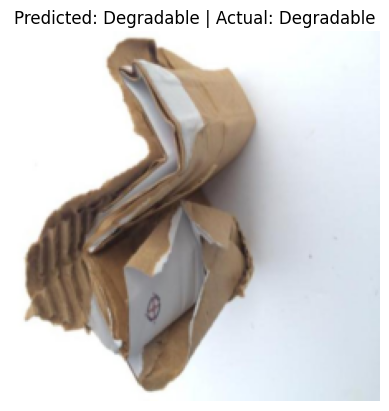

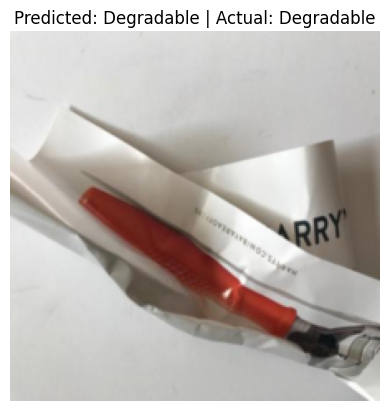

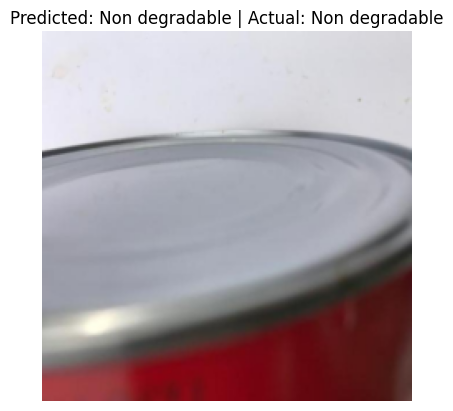

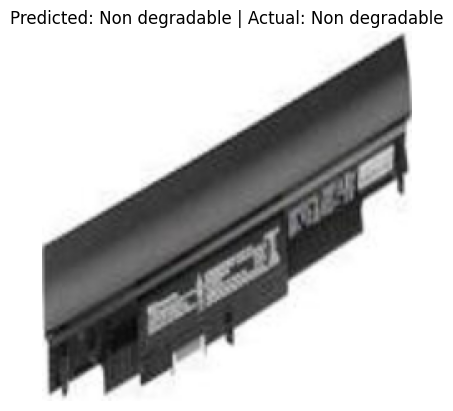

In [5]:
!pip install -q ptflops

# ✅ 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ✅ 2. Imports
import os, random, time
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from ptflops import get_model_complexity_info
import numpy as np

# ✅ 3. Dataset path
data_dir = "/content/drive/MyDrive/dataset"

# ✅ 4. Dataset validation
print("\n📁 Dataset Validation:")
for split in ["train", "valid", "test"]:
    for cls in ["Degradable", "Non degradable"]:
        path = os.path.join(data_dir, split, cls)
        if not os.path.exists(path):
            print(f"❌ MISSING: {path}")
        else:
            files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            print(f"✅ {path} - {len(files)} images")
            if len(files) == 0:
                print(f"⚠ No valid image files found in {path}")
print("\n")

# ✅ 5. Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ 6. Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=transform)
valid_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "valid"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=transform)
class_names = train_dataset.classes

# ✅ 7. Hyperparameter grid
param_grid = {
    'lr': [1e-4, 1e-3],
    'optimizer': ['Adam', 'SGD'],
    'batch_size': [16, 32]
}

best_model = None
best_acc = 0
best_config = None

# ✅ 8. Grid Search with Train Accuracy
start_time = time.time()
for lr in param_grid['lr']:
    for opt_name in param_grid['optimizer']:
        for batch_size in param_grid['batch_size']:
            print(f"\n🚀 Training with lr={lr}, optimizer={opt_name}, batch_size={batch_size}")

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

            model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
            model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model = model.to(device)

            criterion = nn.CrossEntropyLoss()
            if opt_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            else:
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

            num_epochs = 3
            for epoch in range(num_epochs):
                model.train()
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                # ✅ Train Accuracy (per epoch)
                model.eval()
                train_correct, train_total = 0, 0
                with torch.no_grad():
                    for inputs, labels in train_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        _, predicted = outputs.max(1)
                        train_total += labels.size(0)
                        train_correct += predicted.eq(labels).sum().item()
                train_acc = 100 * train_correct / train_total
                print(f"📈 Epoch {epoch+1}/{num_epochs} - Train Accuracy: {train_acc:.2f}%")

            # ✅ Validation Accuracy
            valid_correct, valid_total = 0, 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = outputs.max(1)
                    valid_total += labels.size(0)
                    valid_correct += predicted.eq(labels).sum().item()
            valid_acc = 100 * valid_correct / valid_total

            print(f"✅ Final Validation Accuracy: {valid_acc:.2f}%")

            if valid_acc > best_acc:
                best_acc = valid_acc
                best_model = model
                best_config = {'lr': lr, 'optimizer': opt_name, 'batch_size': batch_size}

end_time = time.time()
total_time_sec = end_time - start_time
total_time_min = total_time_sec / 60

print(f"\n⏱ Total Training & Tuning Time: {total_time_sec:.2f} sec ({total_time_min:.2f} min)")
print(f"🏆 Best Config: {best_config}, Accuracy: {best_acc:.2f}%")

# ✅ 9. Evaluate on test set
test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'], shuffle=False)
best_model.eval()
all_preds, all_labels, all_probs = [], [], []
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, predicted = probs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_acc = 100 * correct / total
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
roc_auc = roc_auc_score(all_labels, [p[1] for p in all_probs])

# ✅ Compute final train accuracy
train_loader = DataLoader(train_dataset, batch_size=best_config['batch_size'], shuffle=False)
train_correct, train_total = 0, 0
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()
final_train_acc = 100 * train_correct / train_total

# ✅ 10. Print final metrics
print("\n📊 Final Performance Metrics:")
print(f"✔ Train Accuracy: {final_train_acc:.2f}%")
print(f"✔ Test Accuracy: {test_acc:.2f}%")
print(f"✔ Precision: {precision:.2f}")
print(f"✔ Recall: {recall:.2f}")
print(f"✔ F1 Score: {f1:.2f}")
print(f"✔ ROC-AUC: {roc_auc:.2f}")
print(f"⏱ Total Time: {total_time_sec:.2f} sec ({total_time_min:.2f} min)")

# ✅ 11. Confusion Matrix
print("\n📌 Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# ✅ 12. Model Complexity (safe for CPU)
device_for_flops = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = best_model.to(device_for_flops)
macs, params = get_model_complexity_info(best_model, (3, 224, 224), as_strings=True, print_per_layer_stat=False)
print(f"\n🧠 Model Parameters: {params}")
print(f"⚙ FLOPs: {macs}")

# ✅ 13. Sample Predictions
def predict_from_dataset(dataset, model, class_names, num_images=5):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)
    for idx in indices:
        image, label = dataset[idx]
        input_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            _, predicted = torch.max(output, 1)
        predicted_class = class_names[predicted.item()]
        true_class = class_names[label]
        plt.imshow(F.to_pil_image(image))
        plt.title(f"Predicted: {predicted_class} | Actual: {true_class}")
        plt.axis('off')
        plt.show()

predict_from_dataset(test_dataset, best_model, class_names, num_images=5)
